# M3 tumor segmentation

## Purpose

This notebooks aligns and segments tumor sections then calculates spatial metrics such as distance to the tumor boundary.

## Setup

In [96]:
from pathlib import Path

import anndata as ad
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import scanpy as sc
import shapely as shp

np.random.seed(42)

from petracer.config import colors

base_path, data_path, plot_path, results_path = petracer.config.get_paths("tumor_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

## Helper functions

In [8]:
def transform_geometries(gdf, angle, flip=False, translate=(0, 0), origin=(0, 0)):
    transformed = gdf['geometry'].apply(lambda geom: shp.affinity.rotate(geom, angle, origin=shp.geometry.Point(origin)))
    if flip:
        transformed = transformed.apply(lambda geom: shp.affinity.scale(geom, yfact=-1, origin=shp.geometry.Point(origin)))
    if translate != (0, 0):
        transformed = transformed.apply(lambda geom: shp.affinity.translate(geom, xoff=translate[0], yoff=translate[1]))
    return transformed

def update_centroids(masks):
    centroids = masks.geometry.centroid
    masks["aligned_x"] = centroids.x
    masks["aligned_y"] = centroids.y
    
def largest_polygon(geometry):
    if isinstance(geometry, shp.geometry.MultiPolygon):
        return max(geometry.geoms, key=lambda p: p.area)
    return geometry 

def fill_holes(geometry):
    if isinstance(geometry, shp.geometry.Polygon) and geometry.interiors:
        return shp.geometry.Polygon(geometry.exterior)
    return geometry 

def largest_polygon(geometry):
    if isinstance(geometry, shp.geometry.MultiPolygon):
        return max(geometry.geoms, key=lambda p: p.area)
    return geometry 

def fill_holes(geometry):
    if isinstance(geometry, shp.geometry.Polygon) and geometry.interiors:
        return shp.geometry.Polygon(geometry.exterior)
    elif isinstance(geometry, shp.geometry.MultiPolygon):
        return shp.geometry.MultiPolygon([shp.geometry.Polygon(poly.exterior) for poly in geometry.geoms])
    return geometry

def segment_region(tdata,gene,threshold,max_dist,buffer = 30,connected = True):
    centers = tdata.obs.copy()
    centers["region"] = ((tdata[:,gene].layers["local_expression"] > threshold)[:,0] & 
                         (tdata.obs["tumor_boundary_dist"] < max_dist) & 
                         tdata.obs["within_tumor"] |
                         ((tdata.obs["tumor_boundary_dist"] < 50) & (tdata.obs["lung_boundary_dist"] > 100)))
    centers = centers[centers["region"]].copy()
    centers = gpd.GeoDataFrame(centers, geometry = centers["geometry"])
    regions = centers.groupby('sample',observed = False)['geometry'].apply(
        lambda x: x.buffer(20).union_all()).reset_index()
    regions['geometry'] = regions['geometry'].buffer(buffer).apply(fill_holes).buffer(-buffer)
    if connected:
        regions['geometry'] = regions['geometry'].apply(largest_polygon)
    regions['geometry'] = regions['geometry'].buffer(50).buffer(-50)
    return regions

## Load data

In [97]:
samples = {"F320-3-2":Path("/lab/weissman_imaging/4T1/241028_F320-3-2_MF4+"),
           "F320-3-3":Path("/lab/weissman_imaging/4T1/241220-F320-3-3-MF4++"),
           "F320-3-4":Path("/lab/weissman_imaging/4T1/241103_F320-3-4_MF4++"),
           "F320-4-3":Path("/lab/weissman_imaging/4T1/241213_F320-4-3_MF4++")}
sample_names = {"F320-3-2": "M3-1","F320-3-3": "M3-2","F320-3-4": "M3-3","F320-4-3": "M3-4"}

In [99]:
adata = sc.read_h5ad(data_path /"M3.h5ad")
adata.obs["tumor"] = "1"
masks = []
for sample, path in samples.items():
    cell_masks = gpd.read_file(path / "polygons_union.json")
    cell_masks['sample'] = sample_names[sample]
    cell_masks['cellBC'] = sample_names[sample] + "-" + cell_masks["cell"].astype(str)
    cell_masks = cell_masks[cell_masks['cellBC'].isin(adata.obs['cellBC'])]
    masks.append(cell_masks)
masks = pd.concat(masks)
masks.crs = None
masks["sample"] = pd.Categorical(masks["sample"], categories=sample_names.values())

## Overlay

Specify rotation, flip, and translation for each sample

<Axes: >

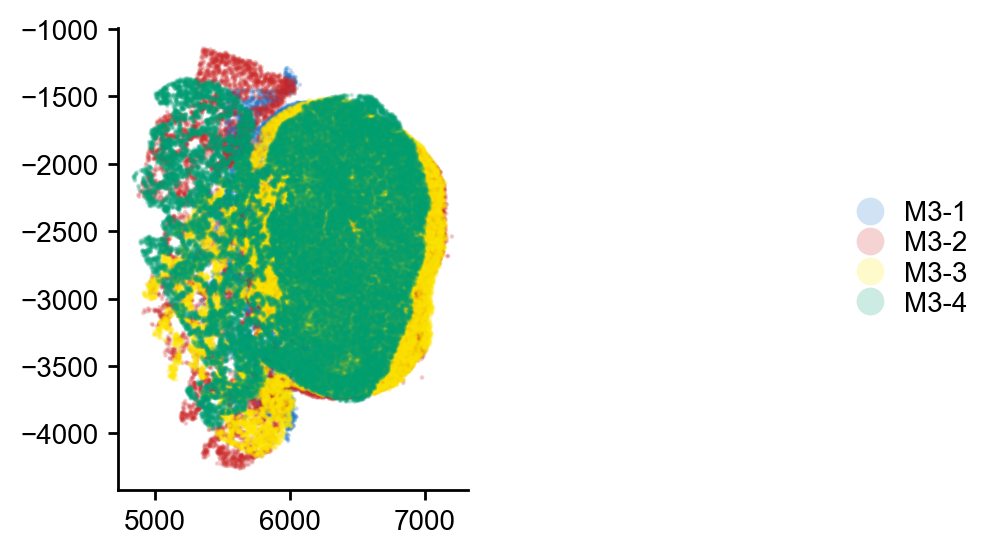

In [ ]:
sample_rotation = {"M3-1": 0, "M3-2": 167, "M3-3": 62, "M3-4": 30}
sample_flip = {"M3-1": False, "M3-2":False,  "M3-3": False, "M3-4": False}
sample_translation = {"M3-1": (0,0), "M3-2": (-500,-1660), "M3-3": (-1300,-1700),  "M3-4": (400,-1750)}
for sample in sample_names.values():
    masks.loc[masks["sample"] == sample,"geometry"] = transform_geometries(masks.loc[masks["sample"] == sample], 
        angle=sample_rotation[sample], flip=sample_flip[sample], translate=sample_translation[sample])
update_centroids(masks)
masks.index = masks["cellBC"]
masks_overlay = masks.copy()
centroids = masks.copy()
centroids.geometry = masks.geometry.centroid
centroids.plot(column='sample', legend=True, s = .5,alpha = .2,
            cmap=mcolors.ListedColormap(colors[1:len(set(masks['sample'])) + 1]),
             legend_kwds={'loc': 'right', "bbox_to_anchor": (2.5, 0.5)})

## Grid

<Axes: >

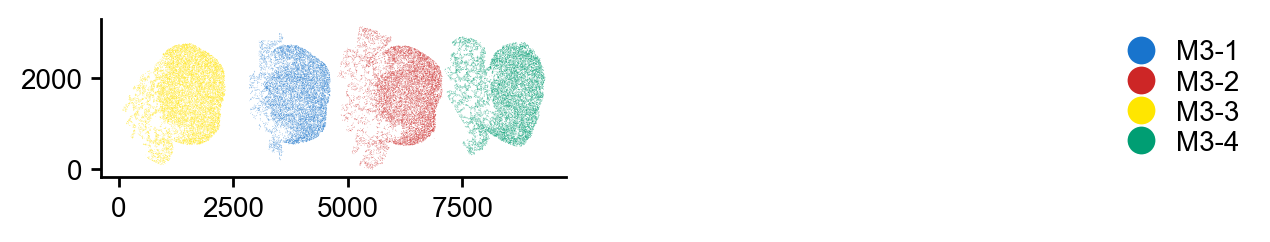

In [102]:
masks = masks_overlay.copy()
x_offset = 0
y_offset = 0
bounds = masks.total_bounds
for sample in ['M3-3','M3-1', 'M3-2', 'M3-4']:
    if sample in masks["sample"].unique():
        indicies = masks.query("sample == @sample").index
        masks.loc[indicies,"geometry"] = transform_geometries(masks.loc[indicies], angle=0, flip=False, 
                                                              translate=(x_offset - bounds[0]
                                                                         , y_offset - bounds[1]))
        x_offset += bounds[2] - bounds[0] 
update_centroids(masks)
masks_grid = masks.copy()
masks.sample(50000).plot(column='sample', legend=True
                         , cmap=mcolors.ListedColormap(colors[1:len(set(masks['sample'])) + 1])
                          , legend_kwds={'loc': 'right', "bbox_to_anchor": (2.5, 0.5)})

## Tumor segmentation

In [ ]:
adata_list = []
tumor_masks_dict = {}
tumor_boundaries_dict = {}
lung_boundaries_dict = {}
for i in adata.obs['sample'].cat.categories:
    adata_sample = adata[adata.obs['sample'] ==i].copy()
    masks_sample = masks_overlay[masks_overlay['sample'] == i].copy()
    malignant_adata = adata_sample[adata_sample.obs["cell_subtype"].isin(["Malignant"
                                                                          , "Malignant_cycling"])]
    centers = gpd.GeoDataFrame(adata_sample.obs, geometry=masks_sample.geometry.centroid)
    malignant_centers = gpd.GeoDataFrame(malignant_adata.obs
                                         , geometry=masks_sample[masks_sample.index.isin(
                                             malignant_adata.obs.index)].geometry.centroid)
    tumor_masks = malignant_centers.groupby('tumor',observed = False)['geometry'].apply(
        lambda x: x.buffer(20).union_all()).reset_index()
    tumor_masks['geometry'] = tumor_masks['geometry'].buffer(100).apply(fill_holes).buffer(-100)
    tumor_masks['geometry'] = tumor_masks['geometry'].apply(largest_polygon)
    tumor_masks['geometry'] = tumor_masks['geometry'].apply(fill_holes).buffer(50).buffer(-30)
    tumor_boundaries = tumor_masks.copy()
    tumor_masks['geometry'] = tumor_masks['geometry'].simplify(tolerance = 10)
    tumor_boundaries['geometry'] = tumor_boundaries['geometry'].boundary
    adata_sample.obs["tumor_boundary_dist"] = gpd.sjoin_nearest(centers[["geometry"]], tumor_boundaries
                                                         , distance_col="tumor_boundary_dist"
                                                        )["tumor_boundary_dist"]
    adata_sample.obs["within_tumor"] = centers.geometry.within(tumor_masks.union_all())
    lung_adata = adata_sample[adata_sample.obs['cell_subtype'].isin(['AT1_AT2', 'Club_cell'])]
    lung_centers = gpd.GeoDataFrame(lung_adata.obs
                                    , geometry=masks_sample[masks_sample.index.isin(
                                        lung_adata.obs.index)].geometry.centroid)
    lung_boundaries = lung_centers.groupby('sample',observed = False)['geometry'].apply(
        lambda x: x.buffer(200).union_all()).reset_index()
    lung_boundaries['geometry'] = lung_boundaries['geometry'].apply(fill_holes).difference(
        tumor_masks.union_all()).apply(largest_polygon).boundary
    adata_sample.obs['lung_boundary_dist'] = gpd.sjoin_nearest(
        centers[["geometry"]], lung_boundaries, distance_col="lung_boundary_dist"
        , how = "left")["lung_boundary_dist"]
    adata_sample.obs.loc[~adata_sample.obs["within_tumor"], "lung_boundary_dist"] = np.nan
    #adata_sample.obs.loc[adata_sample.obs["lung_boundary_dist"] > 1000, "lung_boundary_dist"] = 1000
    adata_list.append(adata_sample)
    tumor_masks_dict[i] = tumor_masks
    tumor_boundaries_dict[i] = tumor_boundaries
    lung_boundaries_dict[i] = lung_boundaries
adata = ad.concat(adata_list)

In [125]:
adata.obsm["spatial"] = masks_grid[['aligned_x', 'aligned_y']].loc[adata.obs_names,:].values

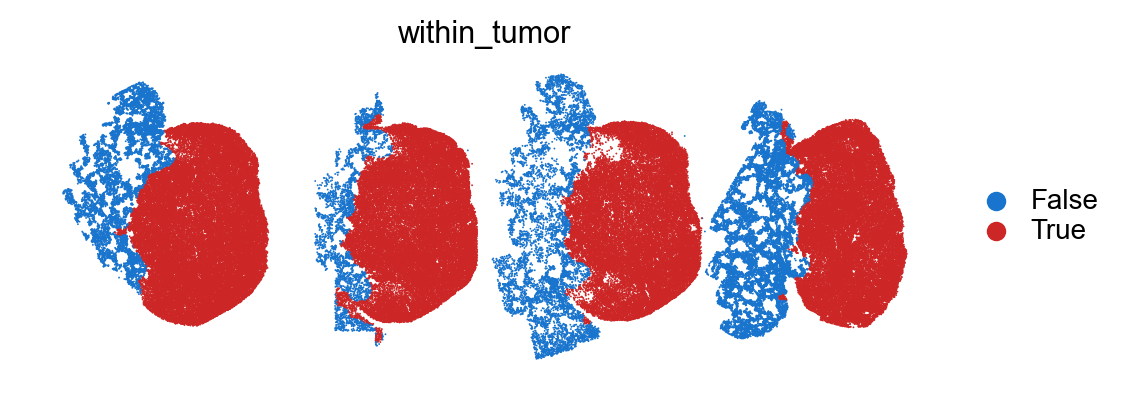

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))
sc.pl.spatial(adata, color='within_tumor',spot_size=20,frameon=False,ax=ax)

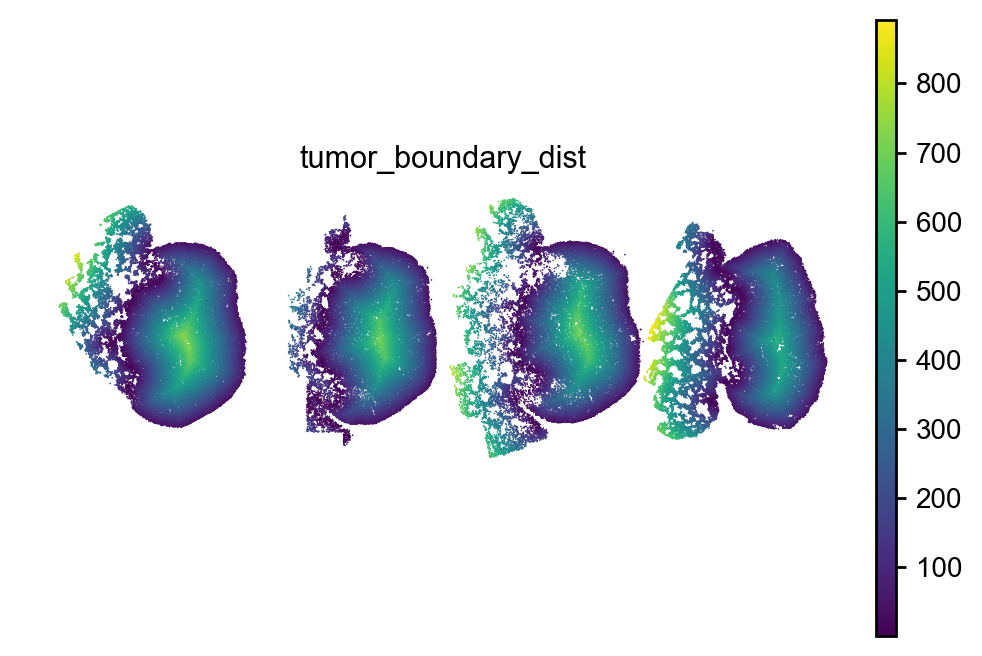

In [128]:
fig, ax = plt.subplots(figsize=(6, 4))
sc.pl.spatial(adata, color='tumor_boundary_dist',spot_size=20,frameon=False,ax=ax)

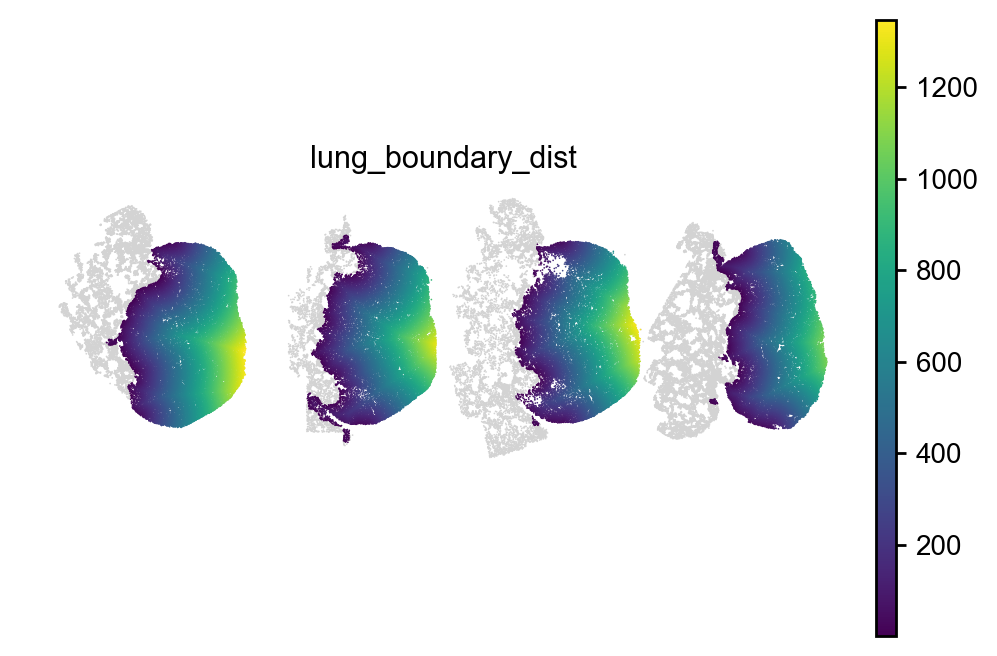

In [130]:
fig, ax = plt.subplots(figsize=(6, 4))
sc.pl.spatial(adata, color='lung_boundary_dist',spot_size=20,frameon=False,ax=ax)

## Module segmentation

Rough segmentation of Hotspot modules

In [ ]:
centers = gpd.GeoDataFrame(adata_sample.obs, geometry=adata.obs.geometry.centroid)
regions = centers.groupby('hotspot_module',observed = False)['geometry'].apply(
        lambda x: x.buffer(30).union_all()).reset_index()
regions['geometry'] = regions['geometry'].buffer(-30).apply(fill_holes)
regions = regions.explode()
regions.plot(column = "hotspot_module",legend = False,facecolor = "none")

Smooth segmentation

In [ ]:
smoothed_regions = regions[regions.area > 50000].copy()
smoothed_regions['geometry'] = smoothed_regions['geometry'].buffer(-20).buffer(22).simplify(10)
smoothed_regions.plot(column = "hotspot_module",legend = False,facecolor = "none")

Remove overlaps

In [ ]:
final_regions = None
for module in ["2","1","4","3"]:
    module_regions = smoothed_regions.query("hotspot_module == @module").dissolve()
    if final_regions is None:
        final_regions = module_regions
    else:
        module_regions.geometry = module_regions.geometry.difference(final_regions.geometry.union_all())
        final_regions = pd.concat([final_regions,module_regions])
final_regions = final_regions.sort_values("hotspot_module")

## Write data

Adata

In [135]:
adata.obsm["spatial_grid"] = masks_grid[['aligned_x', 'aligned_y']].loc[adata.obs_names,:].values
adata.obsm["spatial_overlay"] = masks_overlay[['aligned_x', 'aligned_y']].loc[adata.obs_names,:].values
adata.write(data_path / "M3.h5ad")

Polygons

In [140]:
masks_overlay[['geometry']].to_file(data_path / "M3_polygons_overlay.json", driver="GeoJSON")
masks_grid[['geometry']].to_file(data_path / "M3_polygons_grid.json", driver="GeoJSON")

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
2025-01-10 09:55:38 - Created 145,987 records
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
2025-01-10 09:55:48 - Created 145,987 records


Tumor boundary

In [142]:
tumor_boundaries = []
for x, y in tumor_boundaries_dict.items():
    y['sample'] = x
    tumor_boundaries.append(y)
tumor_boundaries = pd.concat(tumor_boundaries)
tumor_boundaries.to_file(data_path / "M3_tumor_boundaries.json", driver="GeoJSON")

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
2025-01-10 09:56:05 - Created 4 records


Module regions

In [ ]:
final_regions.to_file(results_path / "M3_hotspot_regions.json",driver = "GeoJSON")